<a href="https://colab.research.google.com/github/KaviniWickramasooriya/DL-Lab_06/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [65]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [66]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [67]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [68]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        # Get current state
        state = self.environment.current_location

        # Epsilon-greedy policy
        if np.random.random() < self.epsilon:
            # Exploration: choose random action
            action = np.random.choice(available_actions)
        else:
            # Exploitation: choose action with highest Q-value
            q_values = self.q_table[state]
            max_q = max(q_values.values())
            # If multiple actions have the same max Q-value, choose randomly among them
            best_actions = [action for action, q in q_values.items() if q == max_q]
            action = np.random.choice(best_actions)

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        # Get current Q-value for the state-action pair
        current_q = self.q_table[old_state][action]

        # Get maximum Q-value for the next state
        if new_state in self.environment.terminal_states:
            future_q = 0  # No future rewards in terminal states
        else:
            future_q = max(self.q_table[new_state].values())

        # Q-learning update rule: Q(s,a) = Q(s,a) + alpha * (reward + gamma * max(Q(s',a')) - Q(s,a))
        self.q_table[old_state][action] = current_q + self.alpha * (reward + self.gamma * future_q - current_q)


In [69]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [70]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = (5, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

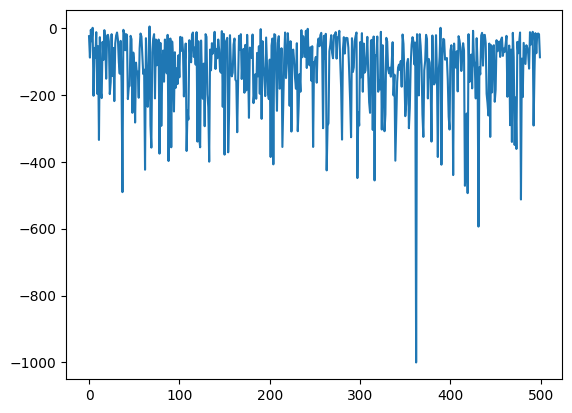

In [71]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

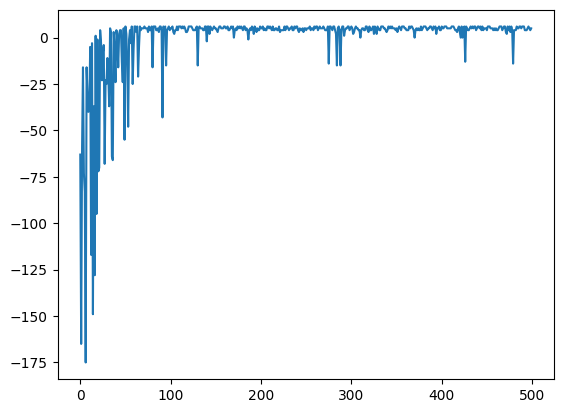

In [72]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [73]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.31910000000000005
	LEFT
		-0.30000000000000004
	RIGHT
		-0.23807179
(0, 1)
	UP
		0.16538914615118142
	DOWN
		0.024249949114065444
	LEFT
		-0.1
	RIGHT
		4.588652083822415
(0, 2)
	UP
		3.588388957551016
	DOWN
		2.167999999983819
	LEFT
		0.9520847234994693
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		2.4168259006648243
	DOWN
		0.7918490200490717
	LEFT
		9.999973843107256
	RIGHT
		1.0158882108926222
(0, 5)
	UP
		-0.1
	DOWN
		-0.11000000000000001
	LEFT
		4.897013858018685
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.3099
	LEFT
		-0.2568400489
	RIGHT
		-0.31000000000000005
(0, 7)
	UP
		-0.4
	DOWN
		-0.43439
	LEFT
		-0.38910000000000006
	RIGHT
		-0.4
(1, 0)
	UP
		-0.541919
	DOWN
		-0.57479293709
	LEFT
		-0.5
	RIGHT
		-0.4973292654180721
(1, 1)
	UP
		-0.297559
	DOWN
		-0.32891000000000004
	LEFT
		-0.31
	RIGHT
		3.729882118041217
(1, 2)
	UP
		8.999999999999986
	DOWN
		4.375763422076708
	LEFT
		0.

##Task - Effect of Grid Size on Execution Time and Convergence

Random Agent Execution Time: 17.699206590652466 seconds
Q-Learning Agent Execution Time: 6.802468538284302 seconds
Random Agent Avg Reward (last 50 episodes): -830.72
Q-Learning Agent Avg Reward (last 50 episodes): -105.14


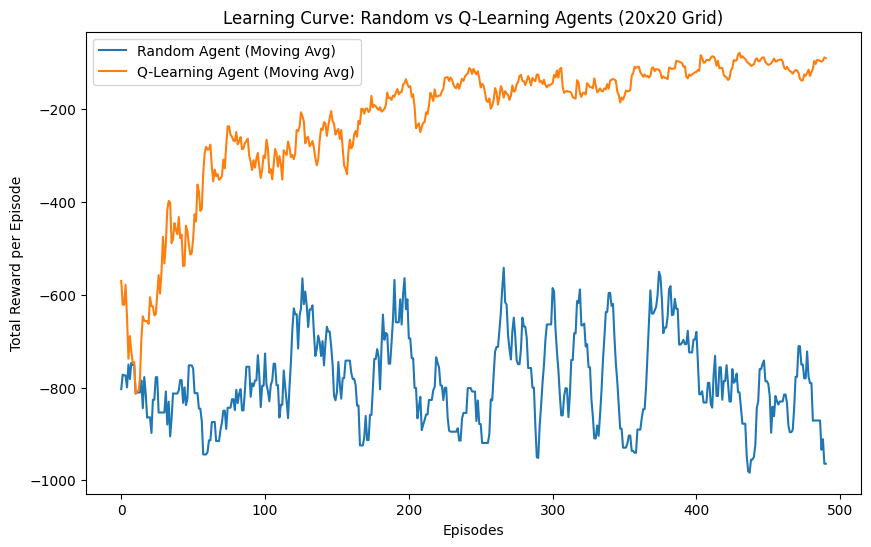

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# GridWorld class with 20x20 grid
class GridWorld:
    def __init__(self):
        # Set information about the gridworld
        self.height = 20
        self.width = 20
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent (bottom row, random col 0-9)
        self.current_location = (19, np.random.randint(0, 10))

        # Set locations for the bomb and the gold
        self.bomb_location = (1, 10)
        self.gold_location = (0, 10)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        """Moves the agent in the specified direction with 0.8 probability, 0.2 to others.
        If agent is at a border, agent stays still but takes negative reward.
        Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # Define intended move
        intended_location = list(self.current_location)
        if action == 'UP':
            intended_location[0] -= 1
        elif action == 'DOWN':
            intended_location[0] += 1
        elif action == 'LEFT':
            intended_location[1] -= 1
        elif action == 'RIGHT':
            intended_location[1] += 1

        # Check if intended move is within bounds
        if 0 <= intended_location[0] < self.height and 0 <= intended_location[1] < self.width:
            move_probs = {action: 0.8}
            other_actions = [a for a in self.actions if a != action]
            for oa in other_actions:
                move_probs[oa] = 0.2 / (len(self.actions) - 1)
        else:
            # If move is out of bounds, stay in place with reward
            self.current_location = last_location
            return self.get_reward(last_location)

        # Choose actual action based on probabilities
        chosen_action = np.random.choice(self.actions, p=[move_probs.get(a, 0.2/3) for a in self.actions])

        # Execute chosen action
        if chosen_action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif chosen_action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif chosen_action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)
        elif chosen_action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# Random Agent
class RandomAgent:
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

# Q-Learning Agent
class Q_Agent:
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = dict()
        for x in range(environment.height):
            for y in range(environment.width):
                self.q_table[(x, y)] = {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}

    def choose_action(self, available_actions):
        """Returns the action to take using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.q_table[self.environment.current_location]
            max_q = max(q_values.values())
            return np.random.choice([action for action, value in q_values.items() if value == max_q])

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-table using the Q-learning update rule"""
        old_q = self.q_table[old_state][action]
        future_q = max(self.q_table[new_state].values()) if new_state not in self.environment.terminal_states else 0
        self.q_table[old_state][action] = old_q + self.alpha * (reward + self.gamma * future_q - old_q)

# Play function to run episodes
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """Runs the agent in the environment for a number of trials"""
    reward_per_episode = []
    for trial in range(trials):
        total_reward = 0
        environment.current_location = (19, np.random.randint(0, 10))  # Reset to random start
        steps = 0
        while steps < max_steps_per_episode:
            old_state = environment.current_location
            action = agent.choose_action(environment.get_available_actions())
            reward = environment.make_step(action)
            total_reward += reward
            new_state = environment.current_location
            if learn:
                agent.learn(old_state, reward, new_state, action)
            if environment.check_state() == 'TERMINAL':
                break
            steps += 1
        reward_per_episode.append(total_reward)
    return reward_per_episode

# Moving average for smoother learning curves
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Run simulations with timing
# Random Agent
start_time_random = time.time()
environment = GridWorld()
agent_random = RandomAgent()
reward_per_episode_random = play(environment, agent_random, trials=500, learn=False)
end_time_random = time.time()
print(f"Random Agent Execution Time: {end_time_random - start_time_random} seconds")

# Q-Learning Agent
start_time_q = time.time()
environment = GridWorld()
agent_q = Q_Agent(environment, epsilon=0.05, alpha=0.1, gamma=1)
reward_per_episode_q = play(environment, agent_q, trials=500, learn=True)
end_time_q = time.time()
print(f"Q-Learning Agent Execution Time: {end_time_q - start_time_q} seconds")

# Print average rewards for last 50 episodes
print(f"Random Agent Avg Reward (last 50 episodes): {np.mean(reward_per_episode_random[-50:])}")
print(f"Q-Learning Agent Avg Reward (last 50 episodes): {np.mean(reward_per_episode_q[-50:])}")

# Plot learning curves (total rewards per episode, with moving average)
plt.figure(figsize=(10, 6))
plt.plot(moving_average(reward_per_episode_random), label='Random Agent (Moving Avg)')
plt.plot(moving_average(reward_per_episode_q), label='Q-Learning Agent (Moving Avg)')
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode')
plt.title('Learning Curve: Random vs Q-Learning Agents (20x20 Grid)')
plt.legend()
plt.savefig('learning_curve_20x20.png')  # Save for screenshot
plt.show()